### Motivation

In this analysis we will have a look at both the performance of the Rust stereo delay compared to its C counterpart and the resulting audio file.

### Prerequisites

In [5]:
install.packages(c("seewave", "signal", "tuneR", "ggplot2", "microbenchmark"))

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [6]:
library(seewave)
library(tuneR)
library(ggplot2)
library(microbenchmark)

### Performance comparison

Despite of all the syntactic sugar, the memory safety, and the feeling to be part of the 21st century, the most important feature of a LADSPA plugin written in `Rust` should be its performance. Since it is using the `C` ABI and the compiled objects can be called from `C` without any overhead, I had the expectation that it would run almost as fast as its `C` counterpart.

Let's first try it with a wrapper around a wrapper. The `microbenchmark` is a `R` function calling `apply_delay.sh` 200 times and reporting some summary statistics about the time taken during execution. This script is a wrapper around the `applyplugin` binary shipped with the [ladspa_sdk](https://www.ladspa.org/download/index.html). It sets up a LADSPA host, plays back the input audio file and pipes the result - modulated by the supplied LADSPA plugin - into the output audio file.

In [13]:
benchmark.c <- microbenchmark(
    system2("bash", c("apply_delay.sh", "delay_snare_c.wav", 
                      "./c/delay_stereo.so", "c_delay_5s_stereo"),
            stdout = FALSE), times = 200)
benchmark.rust <- microbenchmark(
    system2("bash", c("apply_delay.sh", "delay_snare_rust.wav",
                      "./rust/target/release/librust_delay_5s_stereo.so",
                      "rust_delay_5s_stereo"), 
            stdout = FALSE), times = 200)

In [15]:
print(benchmark.c)

Unit: milliseconds
                                                                                                                       expr
 system2("bash", c("apply_delay.sh", "delay_snare_c.wav", "./c/delay_stereo.so",      "c_delay_5s_stereo"), stdout = FALSE)
      min      lq     mean   median       uq      max neval
 16.33747 17.0486 17.79931 17.28952 17.61409 29.58463   200


In [16]:
print(benchmark.rust)

Unit: milliseconds
                                                                                                                                                          expr
 system2("bash", c("apply_delay.sh", "delay_snare_rust.wav", "./rust/target/release/librust_delay_5s_stereo.so",      "rust_delay_5s_stereo"), stdout = FALSE)
      min       lq     mean  median       uq      max neval
 20.89194 21.31846 22.11495 21.6921 22.11272 30.38315   200


Well, this doesn't look good at all.

The `Rust` version takes a lot longer than the `C` counterpart. Also mind the fact that we used a wrapper around a wrapper! So, the relative increase in the time taken by processing the plugin is probably a lot larger than 22.11/17.79. This is not good at all and more or less a red line being crossed making `Rust` a language not suitable for writing LADSPA plugins.

### Comparing the results

But let's have a look at the original and the delayed samples.

In [18]:
sample.original <-
  readWave("./snare.wav")
sample.delayed.rust <-
  readWave("./delay_snare_rust.wav")
sample.delayed.c <-
  readWave("./delay_snare_c.wav")

Plot the files into one figure. Since we expect the `Rust` and `C` to produce exactly the same result, both figures should be identically and one should hide the other.

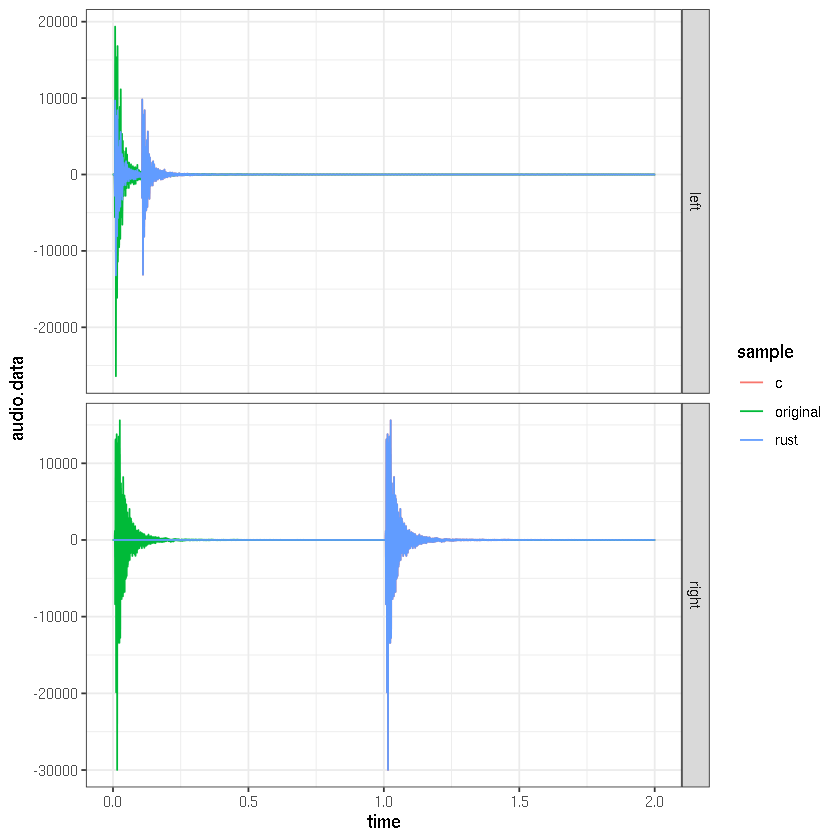

In [19]:
plot.data <- data.frame(
    time = rep(seq(1, length(sample.original@left))/
               sample.original@samp.rate, 6 ),
    audio.data = c(sample.original@left, sample.delayed.rust@left,
                   sample.delayed.c@left, sample.original@right,
                   sample.delayed.rust@right, sample.delayed.c@right),
    sample = rep(c(rep("original", length(sample.original@left)),
                   rep("rust", length(sample.original@left)),
                   rep("c", length(sample.original@left))), 2),
    channel = c(rep("left", length(sample.original@left) * 3),
                rep("right", length(sample.original@left) * 3)))

ggplot(data = plot.data, aes(x = time, y = audio.data,
                             color = sample)) +
  geom_line() + facet_grid(channel ~ ., scales = "free") + 
  theme_bw()

Well, this looks alright. The results of both channels are exactly what was expected.

Let's be sure the output of both plugins are the same by comparing the underlying data.

In [20]:
difference.data <- data.frame(
    left.channel = sample.delayed.rust@left - sample.delayed.c@left,
    right.channel = sample.delayed.rust@right -
      sample.delayed.c@right)

if (any(max(difference.data) != c(0,0))) {
  warning("The Rust and C plugin do not yield the same result!")
}

Perfect. 